# GAN Architecture with Attention -- Tensorflow implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import pickle
import os
from pathlib import Path
import tensorflow as tf

from keras.layers import Dense, Dropout, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.optimizers import Adam

Using TensorFlow backend.


# Data Pipeline

In [433]:
#cars_mask_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_masks.pickle')
#cars_original_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_original.pickle')
#cars_filter_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_filter.pickle')

cars_mask_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/faces_pp/faces_masks.pickle')
cars_original_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/faces_pp/faces_original.pickle')
cars_filter_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/faces_pp/faces_filter.pickle')

In [434]:
with open(cars_mask_path, 'rb') as file:
    X_mask = pickle.load(file)
    
print(X_mask.shape)

(4000, 3, 64, 64)


In [435]:
with open(cars_original_path, 'rb') as file:
    X_original = pickle.load(file)
    
print(X_original.shape)

(4000, 3, 64, 64)


In [436]:
with open(cars_filter_path, 'rb') as file:
    X_filter = pickle.load(file)
    
print(X_filter.shape)

(4000, 64, 64, 3)


In [441]:
def load_data(X_original_, X_mask_, X_filter_, n_inf, n_sup):
    X_image, X_mask, X_filt = X_original_[n_inf:n_sup], X_mask_[n_inf:n_sup], X_filter_[n_inf:n_sup]
    X_image = X_image.transpose((0, 2, 3, 1))
    X_mask = X_mask.transpose((0, 2, 3, 1))
    #X_image = X_image[:, :, :, 0]
    #X_mask = X_mask[:, :, :, 0]
    #X_image = X_image.reshape(X_image.shape[0], -1)
    #X_mask = X_mask.reshape(X_mask.shape[0], -1)
    return (X_image, X_mask, X_filt)


print("Training Set")
X_train, X_train_mask, X_train_filter = load_data(X_original, X_mask, X_filter, 0, 10)
print('  image', X_train.shape)
print('  masked image', X_train_mask.shape)
print('  mask filter', X_train_filter.shape)

print("Testing Set")
X_test, X_test_mask, X_test_filter = load_data(X_original, X_mask, X_filter, 3000, 3100)
print('  image', X_test.shape)
print('  masked image', X_test_mask.shape)
print('  mask filter', X_test_filter.shape)

Training Set
  image (10, 64, 64, 3)
  masked image (10, 64, 64, 3)
  mask filter (10, 64, 64, 3)
Testing Set
  image (100, 64, 64, 3)
  masked image (100, 64, 64, 3)
  mask filter (100, 64, 64, 3)


In [325]:
def min_max_norm(image):
    max_ = image.max()
    min_ = image.min()
    return (image - min_) / (max_ - min_)
    
def min_max_norm2(image):
    copy_img = image.copy()
    copy_img[copy_img > 1.] = 1.
    copy_img[copy_img < 0.] = 0.
    return copy_img

# Model

In [329]:
image_size = (64, 64, 3)
n_pixels = int(image_size[0]*image_size[1]*image_size[2])

#epochs = 20
#batch_size = 1

In [330]:
tf.reset_default_graph()

with tf.variable_scope("user_inputs"):
    
    mask_filter_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    real_image_targets = tf.placeholder(tf.float32, shape=(None,)+image_size)
    masked_image_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    true_labels = tf.placeholder(tf.float32, shape=[None,2])
    training = tf.placeholder(tf.bool)
    
with tf.variable_scope("approx_net"):
    # ApproxNet
    masked_image_inputs_r = tf.reshape(masked_image_inputs, shape=(-1,n_pixels))
    
    images = tf.layers.dense(masked_image_inputs_r, units=512)
    images = tf.layers.dropout(images, rate=0.3, training=training)
    images = tf.nn.leaky_relu(images, alpha=0.2)
    images = tf.layers.dense(images, units=100) 
    images = tf.layers.dropout(images, rate=0.3, training=training)
    images = tf.nn.leaky_relu(images, alpha=0.2)
    images = tf.layers.dense(images, units=512) 
    images = tf.layers.dropout(images, rate=0.3, training=training)
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    reconstructed_images = tf.layers.dense(images, units=n_pixels, activation=tf.nn.sigmoid)
    reconstructed_images = tf.reshape(reconstructed_images, shape=(-1,)+image_size)
    reconstructed_images = tf.multiply(mask_filter_inputs, reconstructed_images) \
                            + tf.multiply(1-mask_filter_inputs, masked_image_inputs)

with tf.variable_scope("attention_generator"):
    # Encoder
    x = reconstructed_images
    x = tf.layers.conv2d(x, filters=32, kernel_size=4, strides=1, padding="same", activation=tf.nn.leaky_relu)
    x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding="same", activation=tf.nn.leaky_relu)
    
    # Attention Layers
    f_branch = tf.layers.conv2d(x, filters=32, kernel_size=1, strides=1, padding="same")
    g_branch = tf.layers.conv2d(x, filters=32, kernel_size=1, strides=1, padding="same")
    h_branch = tf.layers.conv2d(x, filters=64, kernel_size=1, strides=1, padding="same")
    d_ = f_branch.shape[1]

    f_branch = tf.reshape(f_branch, shape=(-1, f_branch.shape[1]*f_branch.shape[2], f_branch.shape[3]))
    g_branch = tf.reshape(g_branch, shape=(-1, g_branch.shape[1]*g_branch.shape[2], g_branch.shape[3]))
    h_branch = tf.reshape(h_branch, shape=(-1, h_branch.shape[1]*h_branch.shape[2], h_branch.shape[3]))
    
    attention_map = tf.matmul(f_branch, g_branch, transpose_b=True)

    attention_output = tf.matmul(attention_map, h_branch)
    attention_output = tf.reshape(attention_output, shape=(-1, d_, d_, attention_output.shape[2]))
    
    # Decoder
    x = attention_output
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=4, strides=1, padding='same', activation=tf.nn.leaky_relu)
    x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=4, strides=1, padding='same', activation=tf.nn.leaky_relu)
    output_images = x
    output_images = tf.multiply(mask_filter_inputs, output_images) \
                        + tf.multiply(1-mask_filter_inputs, masked_image_inputs) 
        
with tf.variable_scope("discriminator"):
    
    discriminator_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    x = discriminator_input
    x = tf.layers.conv2d(x, filters=16, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.flatten(x)
    x = tf.layers.dense(x, units=50, activation=tf.nn.relu)
    class_logits = tf.layers.dense(x, units=2)
    
with tf.variable_scope('losses'):
    #reco_loss1 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - reconstructed_images)*mask_filter_inputs))
    reco_loss1 = tf.losses.absolute_difference(real_image_targets*mask_filter_inputs,reconstructed_images*mask_filter_inputs)
    
    #reco_loss2 = tf.reduce_mean(tf.nn.l2_loss(real_image_targets - output_images)) #/ tf.reduce_sum(mask_filter_inputs)
    reco_loss2 = tf.losses.absolute_difference(real_image_targets, output_images)
    
    reco_loss_approx = tf.losses.absolute_difference(real_image_targets, reconstructed_images)
    
    #perception_loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.)) \
    #                  -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, output_images, max_val=1.))

    # will be fed with both fake/real images only
    #g_loss_reco = reco_loss2 #+ reco_loss1
    g_loss = reco_loss2
    a_loss = reco_loss_approx
    d_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, 
                                                                    logits=class_logits,
                                                                    name="d_loss"))
    
with tf.variable_scope('Optimizer'):
    # For the Attention Encoder Decoder
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    vars_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "attention_generator") 
    train_op_g = optimizer_g.minimize(g_loss, var_list=vars_g)
    
    # For the ApproxNet
    optimizer_a = tf.train.RMSPropOptimizer(learning_rate=0.0001)
    vars_a = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "approx_net") 
    train_op_a = optimizer_a.minimize(a_loss, var_list=vars_a)
    
    # For the Discriminator
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    vars_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 
    train_op_d = optimizer_d.minimize(d_loss, var_list=vars_d)

In [331]:
# /!\/!\/!\/!\/!\
sess_gan = tf.Session()
    
sess_gan.run(tf.global_variables_initializer())
# /!\/!\/!\/!\/!\

history = {'loss_g':[], 'loss_a':[], 'loss_d':[]}

#### PRE TRAIN ApproxNet

In [ ]:
epochs_approxnet = 100
batch_size = 10

for epoch in range(epochs_approxnet):
    for i in range(X_train.shape[0] // batch_size):
        # Freeze all and train ApproxNet only
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        feed_dict = {mask_filter_inputs: X_train_filter[idx],
                     real_image_targets: X_train[idx],
                     masked_image_inputs: X_train_mask[idx],
                     training: True}
        _, train_loss_a = sess_gan.run([train_op_a, a_loss], feed_dict=feed_dict)
        
        history['loss_a'].append(train_loss_a)
        
    if epoch % 1 == 0:
        idx = np.random.randint(0, X_test.shape[0], 30)
        feed_dict = {masked_image_inputs: X_test_mask[idx],
                     mask_filter_inputs: X_test_filter[idx],
                     real_image_targets: X_test[idx],
                     training: False}
        test_a_loss = sess_gan.run(a_loss, feed_dict=feed_dict)
        print("Epoch {0}/{1} \ttrain A loss {2} \ttest A loss {3}"\
              .format(epoch, epochs_approxnet, train_loss_a, test_a_loss))

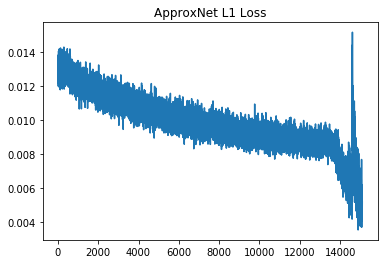

In [440]:
# Learning Curve
plt.plot(history['loss_a'])
plt.title("ApproxNet L1 Loss")
#plt.ylim(0,0.1)
plt.show()

#### Train the attention Encoder Decoder

In [ ]:
epochs_att = 20
batch_size = 10

for epoch in range(epochs_att):
    for i in range(X_train.shape[0] // batch_size):
        # Freeze D and train Generator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        feed_dict = {mask_filter_inputs: X_train_filter[idx],
                     real_image_targets: X_train[idx],
                     masked_image_inputs: X_train_mask[idx],
                     training:True}
        _, train_loss_g = sess_gan.run([train_op_g, g_loss], feed_dict=feed_dict)
        
        history['loss_g'].append(train_loss_g)
        
    if epoch % 1 == 0:
        idx = np.random.randint(0, X_test.shape[0], 30)
        feed_dict = {masked_image_inputs: X_test_mask[idx],
                     mask_filter_inputs: X_test_filter[idx],
                     real_image_targets: X_test[idx],
                     training:False}
        test_loss_g = sess_gan.run(g_loss, feed_dict=feed_dict)
        print("Epoch {0}/{1} \ttrain G loss {2} \ttest G loss {3}"\
              .format(epoch, epochs_att, train_loss_g, test_loss_g))

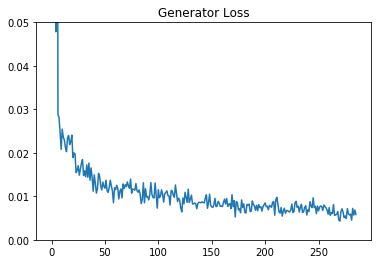

In [444]:
# Learning Curve
plt.plot(history['loss_g'])
plt.title("Generator Loss")
plt.ylim(0,0.05)
plt.show()

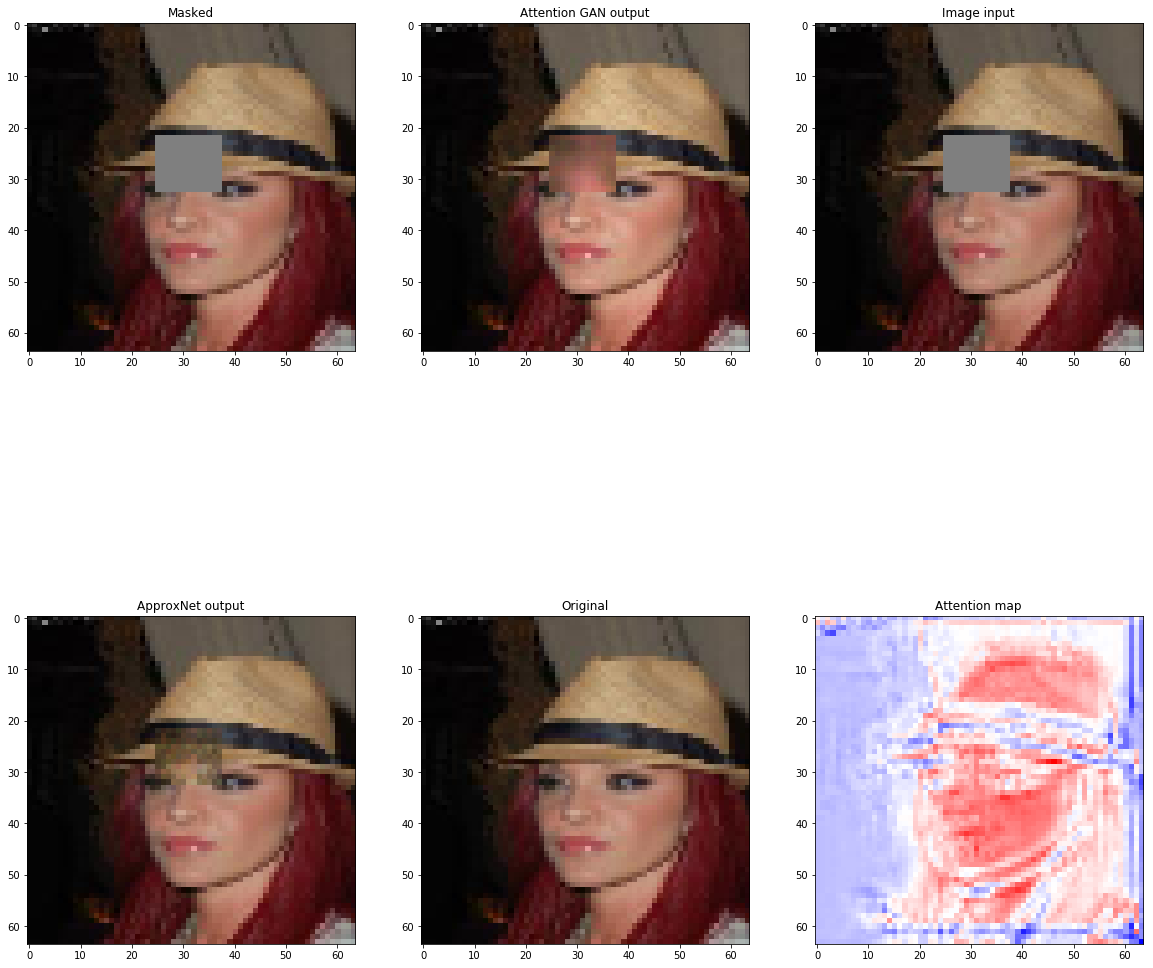

In [445]:
# /!\ TRAIN SET /!\

idx = [4]

feed_dict = {masked_image_inputs: X_train_mask[idx],
             mask_filter_inputs: X_train_filter[idx],
             real_image_targets: X_train[idx],
             training:False}

img_inp, reco, out_imgs, att_map = sess_gan.run([masked_image_inputs, reconstructed_images, output_images, attention_map], 
                                             feed_dict=feed_dict)
plt.figure(figsize=(20, 20))

i1, i2 = 0, idx[0]
plt.subplot(2, 3, 1)
plt.imshow(X_train_mask[i2])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(img_inp[i1])
plt.title("Image input")
plt.subplot(2, 3, 4)
plt.imshow(reco[i1])
plt.title("ApproxNet output")
plt.subplot(2, 3, 2)
#plt.imshow(out_imgs[i])
plt.imshow(min_max_norm(out_imgs[i1]))
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
plt.imshow(att_map[i1][2590].reshape(64, 64), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_train[i2])
plt.title("Original")

plt.show()

0.9818969


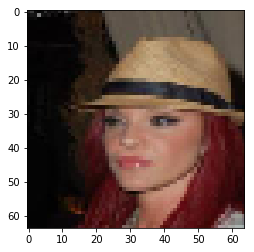

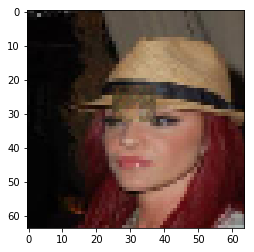

In [446]:
# numpy array
img1_ = X_train[i2]
#img2_ = min_max_norm(out_imgs[i1])
#img2_ = X_train_mask[i2]
img2_ = reco[i1]

# tf placeholder 
img1 = tf.placeholder(tf.float32, shape=(64, 64, 3))
img2 = tf.placeholder(tf.float32, shape=(64, 64, 3))
max_val = 1.

similarity = tf.image.ssim(img1, img2, max_val=1.)

with tf.Session() as sess:
    print(sess.run(similarity, feed_dict={img1:img1_, img2:img2_}))
    #print(sess.run(-similarity, feed_dict={img1:X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i], 
    #                                      img2:X_test[i]}))

plt.imshow(img1_)
plt.show()
plt.imshow(img2_)
plt.show()

#### Train the Discriminator alone

In [ ]:
epochs_disc = 20
batch_size = 10

for epoch in range(epochs_disc):
    for i in range(X_train.shape[0] // batch_size):
        # load batch_size fake images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        fake_images_mask = X_train_mask[idx]
        fake_images_filter = X_train_filter[idx]
        feed_dict = {masked_image_inputs: fake_images_mask,
                     mask_filter_inputs: fake_images_filter}
        fake_images = sess_gan.run(output_images, feed_dict=feed_dict)
        
        # load batch_size real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        real_images_mask = X_train_mask[idx]
        real_images_filter = X_train_filter[idx]
        
        # concatenate and label fake/real
        input_images = np.concatenate([real_images, fake_images])
        input_masks = np.concatenate([real_images_mask, fake_images_mask])
        input_filters = np.concatenate([real_images_filter, fake_images_filter])
        labels = np.zeros((2*batch_size, 2))
        labels[batch_size:, 0] = 1.
        labels[:batch_size, 1] = 1.
        
        # Freeze G train Discriminator
        feed_dict = {discriminator_input: input_images,
                     mask_filter_inputs: input_filters,
                     real_image_targets: input_images,
                     true_labels: labels}
        _, train_loss_d = sess_gan.run([train_op_d, d_loss], feed_dict=feed_dict)
        
        history['loss_d'].append(train_loss_d)
        
    if epoch % 1 == 0:
        #feed_dict = {masked_image_inputs: X_test_mask,
        #             mask_filter_inputs: X_test_filter,
        #             real_image_targets: X_test}
        #test_perception_loss = sess_gan.run(g_loss, feed_dict=feed_dict)
        print("Epoch {0}/{1} \ttrain G loss {2}"\
              .format(epoch, epochs_disc, train_loss_d))


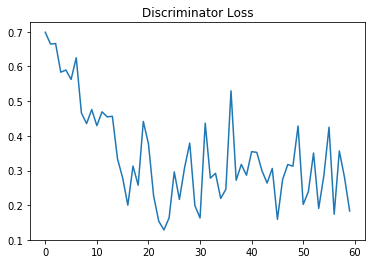

In [71]:
# Learning Curve
plt.plot(history['loss_d'])
plt.title("Discriminator Loss")
#plt.ylim(0,1.)
plt.show()

Logit for Fake: 0.015530088
Logit for Real: -0.04552493


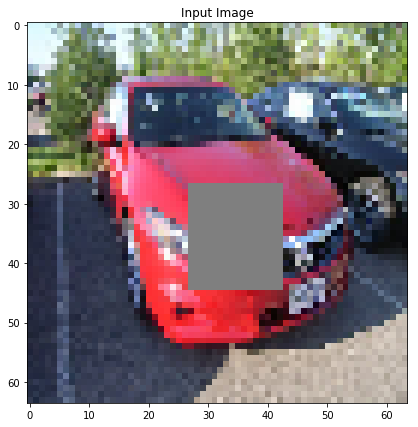

In [166]:
# /!\ TRAIN SET /!\

idx = [1]
img = X_train_mask[idx]

feed_dict = {discriminator_input: img}

logits = sess_gan.run(class_logits, feed_dict=feed_dict)


print("Logit for Fake:", logits[0][1])
print("Logit for Real:", logits[0][0])


plt.figure(figsize=(7, 7))
plt.imshow(img[0])
plt.title("Input Image")
plt.show()

### Colors restauration per channel

In [ ]:
plt.hist(out_imgs[i][:,:,0].flatten(), bins=100)
plt.show()
plt.hist(out_imgs[i][:,:,1].flatten(), bins=100)
plt.show()
plt.hist(out_imgs[i][:,:,2].flatten(), bins=100)
plt.show()
plt.title("Real distribution")
plt.hist(X_train[i].flatten(), bins=100)
plt.show()

### Similarity 

0.9983897


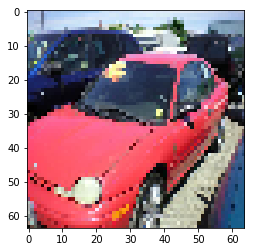

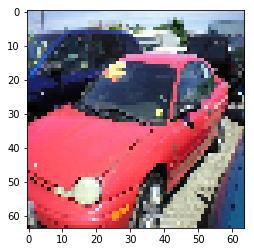

In [353]:
# numpy array
i=97
img1_ = X_train[i2]
img2_ = reco[i1]

# tf placeholder 
img1 = tf.placeholder(tf.float32, shape=(64, 64, 3))
img2 = tf.placeholder(tf.float32, shape=(64, 64, 3))
max_val = 1.

similarity = tf.image.ssim(img1, img2, max_val=1.)

with tf.Session() as sess:
    print(sess.run(similarity, feed_dict={img1:img1_, img2:img2_}))
    #print(sess.run(-similarity, feed_dict={img1:X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i], 
    #                                      img2:X_test[i]}))

plt.imshow(img1_)
plt.show()
plt.imshow(img2_)
plt.show()

### Results on Test set

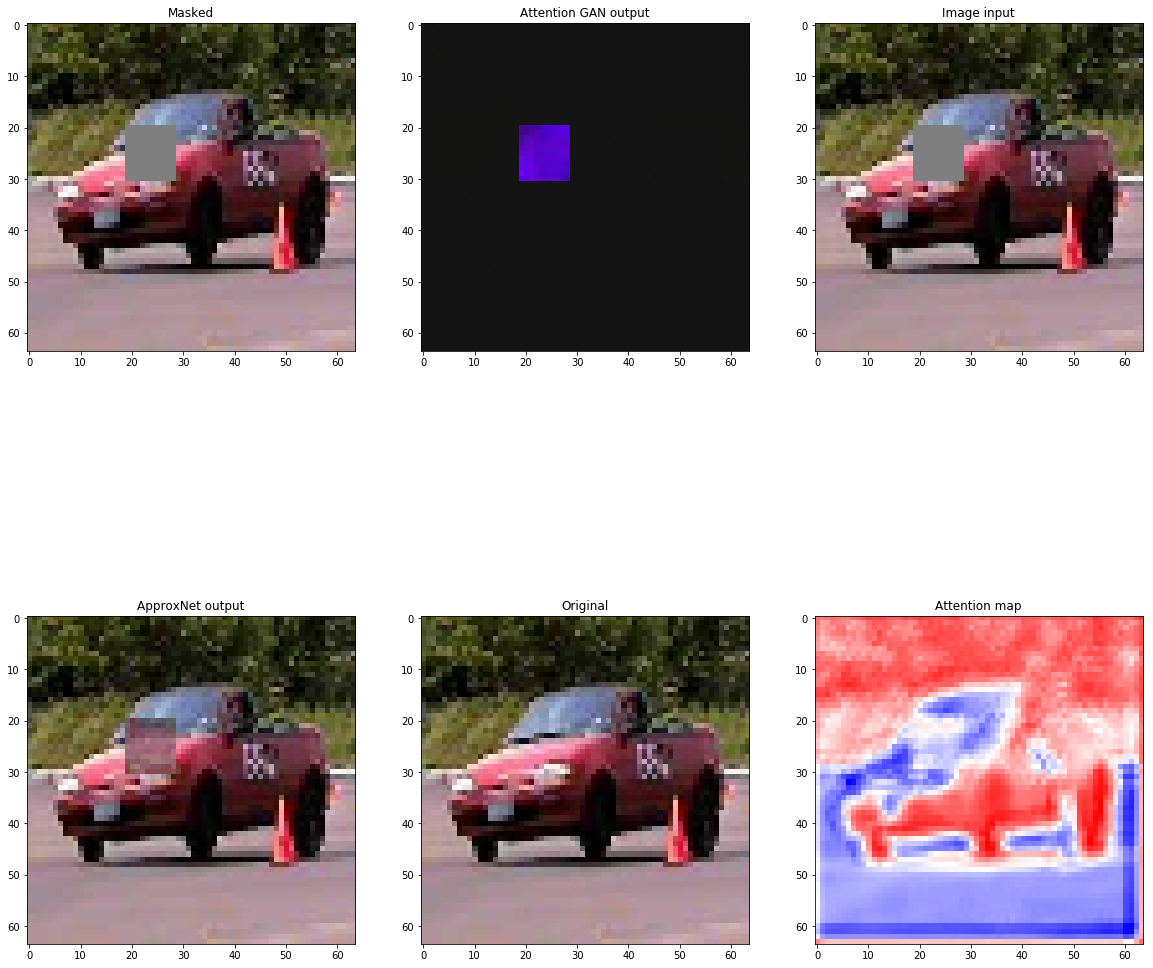

In [364]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test,
             training:False}

img_inp, reco, out_imgs, att_map = sess_gan.run([masked_image_inputs, reconstructed_images, output_images, attention_map], 
                                             feed_dict=feed_dict)
i = 21
plt.figure(figsize=(20, 20))
plt.subplot(2, 3, 1)
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(img_inp[i])
plt.title("Image input")
plt.subplot(2, 3, 4)
plt.imshow(reco[i])
plt.title("ApproxNet output")
plt.subplot(2, 3, 2)
#plt.imshow(out_imgs[i])
plt.imshow(min_max_norm(out_imgs[i]))
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
plt.imshow(att_map[i][3368].reshape(64, 64), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_test[i])
plt.title("Original")

plt.show()

In [ ]:
ssims = []
# tf placeholder 
img1 = tf.placeholder(tf.float32, shape=(64, 64, 3))
img2 = tf.placeholder(tf.float32, shape=(64, 64, 3))
max_val = 1.

# numpy array
for i in range(len(X_test)):
    img1_ = X_test[i]
    img2_ = X_test_mask[i]

    similarity = tf.image.ssim(img1, img2, max_val=1.)

    with tf.Session() as sess:
        simi = sess.run(similarity, feed_dict={img1:img1_, img2:img2_})
        #print(simi)
        #print(sess.run(-similarity, feed_dict={img1:X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i], 
        #                                      img2:X_test[i]}))
        ssims.append(simi)